In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
import seaborn as sns 
import re
 
import warnings # supress warnings
warnings.filterwarnings('ignore')

In [2]:
import sklearn

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, scale, StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.inspection import permutation_importance

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic
from sklearn.gaussian_process.kernels import Kernel, Hyperparameter, ConstantKernel
from sklearn.gaussian_process.kernels import GenericKernelMixin

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score  

from sklearn.pipeline import make_pipeline

from sklearn.base import clone

In [3]:
def run_models():
    rf = RandomForestRegressor(n_estimators= 100, random_state= 10)
    gb = GradientBoostingRegressor(loss='quantile', alpha=0.5,
                                n_estimators=100, max_depth=10,
                                learning_rate=0.25, min_samples_leaf=9,
                                min_samples_split=2)
    lr = LinearRegression()
    rr = Ridge(alpha=0.01)
    lasso = Lasso(alpha=0.01)
    gpr1 = GaussianProcessRegressor(kernel=DotProduct() + WhiteKernel(),random_state=0)
    gpr2 = GaussianProcessRegressor(kernel=1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3))+ 
                                WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1)),alpha=0.0)
    gpr3 = GaussianProcessRegressor(kernel=ConstantKernel(1.0, (1e-2, 1e3)) * RBF(10, (1e-3, 1e4)),
                                n_restarts_optimizer=9)
    gpr4 = GaussianProcessRegressor(kernel=1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)))
    gpr5 = GaussianProcessRegressor(kernel=1.0 * RationalQuadratic(length_scale=1.0, alpha=0.01))
    gpr6 = GaussianProcessRegressor(kernel=1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 10.0),nu=0.35))
    models = [rf,gb,lr,rr,lasso,gpr1,gpr2,gpr3,gpr4,gpr5,gpr6]
    models_names = ["RF","GB","LR","RR","LASSO","gpr1","gpr2","gpr3","gpr4","gpr5","gpr6"]
    r2scores=[]
    rmse=[]
    count=0
    for model in models :
        predicted_y = []
        expected_y = []
        kf = KFold(n_splits= 10) 
        # partition data
        for train_index, test_index in kf.split(X, Y):
            # specific ".loc" syntax for working with dataframes
            x_train, x_test = X.loc[train_index], X.loc[test_index]
            y_train, y_test = Y[train_index], Y[test_index]

            # create and fit classifier
            model.fit(x_train, y_train)

            # store result from classification
            predicted_y.extend(model.predict(x_test))

            # store expected result for this specific fold
            expected_y.extend(y_test)
        
        r2 = metrics.r2_score(expected_y, predicted_y)
        r2scores.append(r2)
        
        err=np.sqrt(metrics.mean_squared_error(expected_y, predicted_y))
        rmse.append(err)
        
        print(models_names[count])
        print("R2: ",r2.__str__())
        print("RMSE: ",err)
        print("---------------------------------------")
        count+=1
    
    plt.rcdefaults()
    fig, ax = plt.subplots()

    x_pos = np.arange(len(models_names))
    ax.bar(x_pos, r2scores, align='center')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(models_names)
    ax.set_ylabel('R2 Score')
    #plt.savefig('imp.eps', format='eps')
    #plt.show()
    print(r2scores)

# Standard Scaling

In [4]:
data_std = pd.read_csv('scaled_standard_Coeff_B.csv', encoding='cp1252')   

In [5]:
data_std.columns.values

array(['Name', 'density', 'mean_A2B', 'mean_A2X', 'mean_B2X', 'mean_X2X',
       'std_A2B', 'std_A2X', 'std_B2X', 'std_X2X', 'E_coh', 'TF', 'OF',
       'A_Z', 'B_Z', 'X_Z', 'A_G', 'B_G', 'X_G', 'A_IEI', 'B_IEI',
       'X_IEI', 'A_IEII', 'B_IEII', 'X_IEII', 'A_EA', 'B_EA', 'X_EA',
       'A_ChiP', 'B_ChiP', 'X_ChiP', 'A_ChiA', 'B_ChiA', 'A_Rvdw',
       'B_Rvdw', 'X_Rvdw', 'B_Rc', 'B_Ra', 'A_MP', 'B_MP', 'A_Rho',
       'B_Rho', 'X_Rho', 'B_MV', 'X_MV', 'B_Hf', 'A_Kappa', 'B_Kappa',
       'X_Kappa', 'A_CvM', 'B_CvM', 'A_B', 'B_B', 'B_MendeleevNo',
       'Coeff_B'], dtype=object)

In [6]:
data_std.drop(['A_Z', 'B_Z', 'X_Z', 'A_G', 'B_G', 'X_G', 'A_IEI', 'B_IEI',
       'X_IEI', 'A_IEII', 'B_IEII', 'X_IEII', 'A_EA', 'B_EA', 'X_EA',
       'A_ChiP', 'B_ChiP', 'X_ChiP', 'A_ChiA', 'B_ChiA', 'A_Rvdw',
       'B_Rvdw', 'X_Rvdw', 'B_Rc', 'B_Ra', 'A_MP', 'B_MP', 'A_Rho',
       'B_Rho', 'X_Rho', 'B_MV', 'X_MV', 'B_Hf', 'A_Kappa', 'B_Kappa',
       'X_Kappa', 'A_CvM', 'B_CvM', 'A_B', 'B_B', 'B_MendeleevNo'
          ], axis=1, inplace = True)

In [7]:
data_std.fillna(0, inplace= True)

In [8]:
Y = data_std['Coeff_B'] 
X = data_std.drop(['Coeff_B','Name'], axis=1)

### Using CV technique

RF
R2:  0.8290482207863523
RMSE:  0.4134631533929567
---------------------------------------
GB
R2:  0.7191630624252262
RMSE:  0.5299405038065819
---------------------------------------
LR
R2:  0.7324638117455715
RMSE:  0.517239004962337
---------------------------------------
RR
R2:  0.7325727540314673
RMSE:  0.5171336828795169
---------------------------------------
LASSO
R2:  0.7331899688516358
RMSE:  0.5165365729049244
---------------------------------------
gpr1
R2:  0.7400510088085523
RMSE:  0.5098519306538396
---------------------------------------
gpr2
R2:  0.7852909665341683
RMSE:  0.4633670612655065
---------------------------------------
gpr3
R2:  0.503714444454599
RMSE:  0.7044753761100533
---------------------------------------
gpr4
R2:  0.5037139547238922
RMSE:  0.7044757236953646
---------------------------------------
gpr5
R2:  0.7710304059129207
RMSE:  0.4785076740106466
---------------------------------------
gpr6
R2:  0.8256331178945349
RMSE:  0.4175726069864559
----

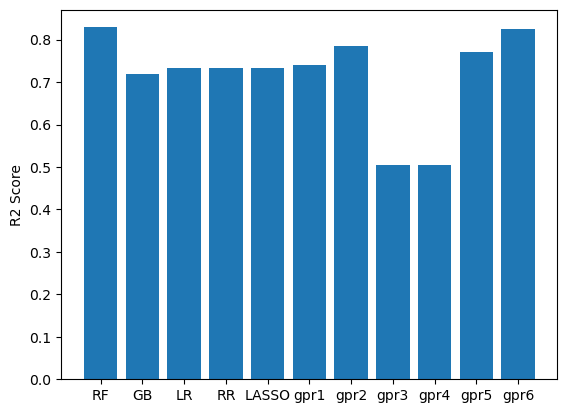

In [9]:
run_models()

## Feature selection


In [10]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature       Score
1   mean_A2B  123.813866
4   mean_X2X   73.889589
2   mean_A2X   50.449602
9      E_coh   31.896431
6    std_A2X   16.320932
7    std_B2X   15.556831
11        OF   15.234473
5    std_A2B    5.573858
8    std_X2X    4.457868
10        TF    3.748590
0    density    0.519052
3   mean_B2X    0.216528


In [11]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['mean_A2B', 'mean_X2X', 'mean_A2X', 'E_coh', 'std_A2X', 'std_B2X',
       'OF', 'std_A2B', 'std_X2X', 'TF', 'density', 'mean_B2X'],
      dtype=object)

In [12]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]

RF
R2:  0.8405348490776499
RMSE:  0.3993308789992957
---------------------------------------
GB
R2:  0.730915755620253
RMSE:  0.5187333075673346
---------------------------------------
LR
R2:  0.7324638117455714
RMSE:  0.5172390049623371
---------------------------------------
RR
R2:  0.7325727540314673
RMSE:  0.5171336828795168
---------------------------------------
LASSO
R2:  0.733166921084627
RMSE:  0.5165588823313108
---------------------------------------
gpr1
R2:  0.740051008808556
RMSE:  0.509851930653836
---------------------------------------
gpr2
R2:  0.7852909665341994
RMSE:  0.463367061265473
---------------------------------------
gpr3
R2:  0.503713454616179
RMSE:  0.7044760786455571
---------------------------------------
gpr4
R2:  0.5037139547238934
RMSE:  0.7044757236953639
---------------------------------------
gpr5
R2:  0.7710304059207733
RMSE:  0.47850767400244126
---------------------------------------
gpr6
R2:  0.8256331178945345
RMSE:  0.41757260698645626
------

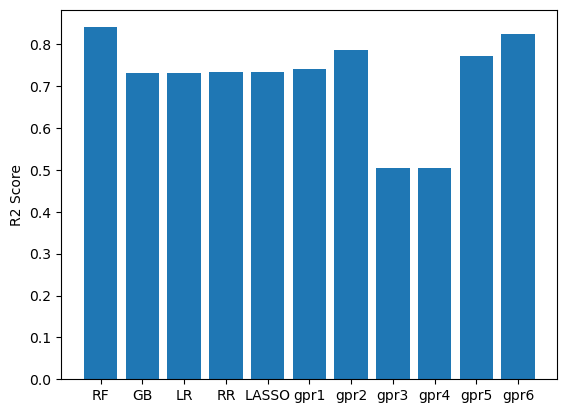

In [13]:
run_models()

In [14]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['mean_A2B', 'mean_X2X', 'mean_A2X', 'E_coh', 'std_A2X', 'std_B2X',
       'OF', 'std_A2B', 'std_X2X', 'TF', 'density', 'mean_B2X'],
      dtype=object)

In [15]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]

RF
R2:  0.8405348490776499
RMSE:  0.3993308789992957
---------------------------------------
GB
R2:  0.7308725592583154
RMSE:  0.5187749422839201
---------------------------------------
LR
R2:  0.7324638117455714
RMSE:  0.5172390049623371
---------------------------------------
RR
R2:  0.7325727540314673
RMSE:  0.5171336828795168
---------------------------------------
LASSO
R2:  0.733166921084627
RMSE:  0.5165588823313108
---------------------------------------
gpr1
R2:  0.740051008808556
RMSE:  0.509851930653836
---------------------------------------
gpr2
R2:  0.7852909665341994
RMSE:  0.463367061265473
---------------------------------------
gpr3
R2:  0.5037136724207512
RMSE:  0.7044759240593313
---------------------------------------
gpr4
R2:  0.5037139547238934
RMSE:  0.7044757236953639
---------------------------------------
gpr5
R2:  0.7710304059207733
RMSE:  0.47850767400244126
---------------------------------------
gpr6
R2:  0.8256331178945345
RMSE:  0.41757260698645626
----

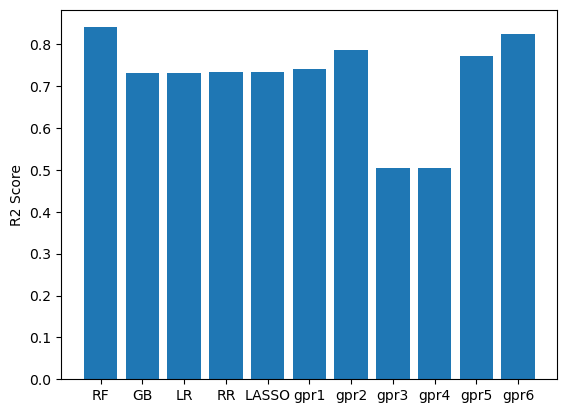

In [16]:
run_models()

In [17]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['mean_A2B', 'mean_X2X', 'mean_A2X', 'E_coh', 'std_A2X', 'std_B2X',
       'OF', 'std_A2B', 'std_X2X', 'TF', 'density', 'mean_B2X'],
      dtype=object)

In [18]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]

RF
R2:  0.8405348490776499
RMSE:  0.3993308789992957
---------------------------------------
GB
R2:  0.7251295509276683
RMSE:  0.5242808875710917
---------------------------------------
LR
R2:  0.7324638117455714
RMSE:  0.5172390049623371
---------------------------------------
RR
R2:  0.7325727540314673
RMSE:  0.5171336828795168
---------------------------------------
LASSO
R2:  0.733166921084627
RMSE:  0.5165588823313108
---------------------------------------
gpr1
R2:  0.740051008808556
RMSE:  0.509851930653836
---------------------------------------
gpr2
R2:  0.7852909665341994
RMSE:  0.463367061265473
---------------------------------------
gpr3
R2:  0.5037139503894169
RMSE:  0.7044757267717484
---------------------------------------
gpr4
R2:  0.5037139547238934
RMSE:  0.7044757236953639
---------------------------------------
gpr5
R2:  0.7710304059207733
RMSE:  0.47850767400244126
---------------------------------------
gpr6
R2:  0.8256331178945345
RMSE:  0.41757260698645626
----

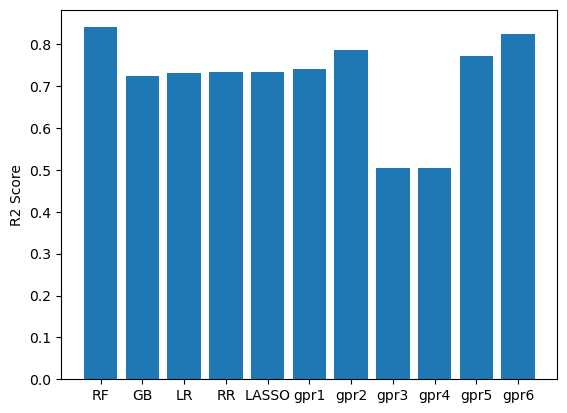

In [19]:
run_models()

In [20]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['mean_A2B', 'mean_X2X', 'mean_A2X', 'E_coh', 'std_A2X', 'std_B2X',
       'OF', 'std_A2B', 'std_X2X', 'TF'], dtype=object)

In [21]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]

RF
R2:  0.8640119500254738
RMSE:  0.3687655759076845
---------------------------------------
GB
R2:  0.6645917913600636
RMSE:  0.5791443763345513
---------------------------------------
LR
R2:  0.656726606184012
RMSE:  0.5858953778755964
---------------------------------------
RR
R2:  0.6568469596311709
RMSE:  0.5857926598796106
---------------------------------------
LASSO
R2:  0.6728592260861702
RMSE:  0.5719622137115613
---------------------------------------
gpr1
R2:  0.6744763422945363
RMSE:  0.5705468058849016
---------------------------------------
gpr2
R2:  0.7415709035100122
RMSE:  0.5083592199321144
---------------------------------------
gpr3
R2:  0.4161644395758456
RMSE:  0.7640913298972541
---------------------------------------
gpr4
R2:  0.416164608147529
RMSE:  0.7640912195886503
---------------------------------------
gpr5
R2:  0.8037876348979793
RMSE:  0.4429586494268067
---------------------------------------
gpr6
R2:  0.8157783660058451
RMSE:  0.4292104774981093
----

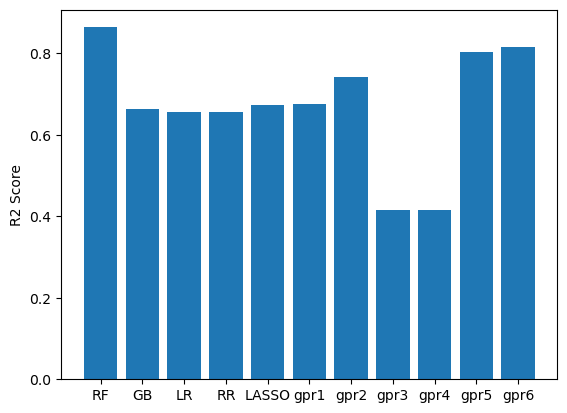

In [22]:
run_models()

# Min-Max scaling

In [23]:
data_mm = pd.read_csv('scaled_minmax_Coeff_B.csv', encoding='cp1252')

In [24]:
data_mm.drop(['A_Z', 'B_Z', 'X_Z', 'A_G', 'B_G', 'X_G', 'A_IEI', 'B_IEI',
       'X_IEI', 'A_IEII', 'B_IEII', 'X_IEII', 'A_EA', 'B_EA', 'X_EA',
       'A_ChiP', 'B_ChiP', 'X_ChiP', 'A_ChiA', 'B_ChiA', 'A_Rvdw',
       'B_Rvdw', 'X_Rvdw', 'B_Rc', 'B_Ra', 'A_MP', 'B_MP', 'A_Rho',
       'B_Rho', 'X_Rho', 'B_MV', 'X_MV', 'B_Hf', 'A_Kappa', 'B_Kappa',
       'X_Kappa', 'A_CvM', 'B_CvM', 'A_B', 'B_B', 'B_MendeleevNo'
          ], axis=1, inplace = True)

In [25]:
data_mm.fillna(0, inplace= True)

In [26]:
Y = data_mm['Coeff_B'] 
X = data_mm.drop(['Coeff_B','Name'], axis=1)

### Using CV technique

RF
R2:  0.8427162352564153
RMSE:  0.10714612749413133
---------------------------------------
GB
R2:  0.7083538723024152
RMSE:  0.14590246811809104
---------------------------------------
LR
R2:  0.7324638117455717
RMSE:  0.13974162812202182
---------------------------------------
RR
R2:  0.7344357568550874
RMSE:  0.1392256746002555
---------------------------------------
LASSO
R2:  0.6267541578185725
RMSE:  0.165056267740283
---------------------------------------
gpr1
R2:  0.7369589245455126
RMSE:  0.1385626935414095
---------------------------------------
gpr2
R2:  0.750520970190337
RMSE:  0.13494337086325553
---------------------------------------
gpr3
R2:  -0.4276075481130228
RMSE:  0.32280403082537606
---------------------------------------
gpr4
R2:  -0.18796488641347064
RMSE:  0.2944667976307778
---------------------------------------
gpr5
R2:  0.7497020659620968
RMSE:  0.13516466233418434
---------------------------------------
gpr6
R2:  0.8135603308993085
RMSE:  0.116655089995

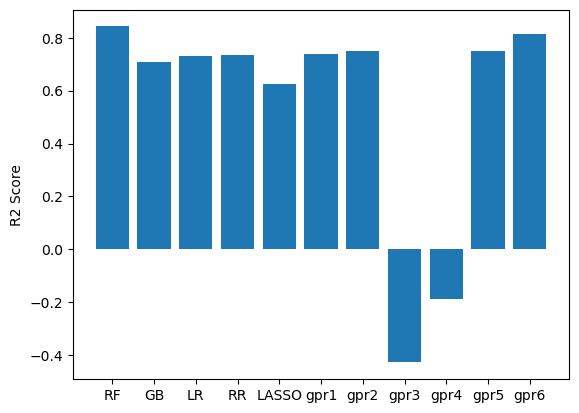

In [27]:
run_models()

## Feature selection


In [28]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature       Score
1   mean_A2B  123.813866
4   mean_X2X   73.889589
2   mean_A2X   50.449602
9      E_coh   31.896431
6    std_A2X   16.320932
7    std_B2X   15.556831
11        OF   15.234473
5    std_A2B    5.573858
8    std_X2X    4.457868
10        TF    3.748590
0    density    0.519052
3   mean_B2X    0.216528


In [29]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['mean_A2B', 'mean_X2X', 'mean_A2X', 'E_coh', 'std_A2X', 'std_B2X',
       'OF', 'std_A2B', 'std_X2X', 'TF', 'density', 'mean_B2X'],
      dtype=object)

In [30]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]

RF
R2:  0.8405910988082123
RMSE:  0.10786755017995549
---------------------------------------
GB
R2:  0.730756753050334
RMSE:  0.14018674145368018
---------------------------------------
LR
R2:  0.7324638117455717
RMSE:  0.1397416281220218
---------------------------------------
RR
R2:  0.7344357568550874
RMSE:  0.1392256746002555
---------------------------------------
LASSO
R2:  0.6267542534553168
RMSE:  0.16505624659410628
---------------------------------------
gpr1
R2:  0.7369589245454992
RMSE:  0.13856269354141304
---------------------------------------
gpr2
R2:  0.7505209701910407
RMSE:  0.13494337086306524
---------------------------------------
gpr3
R2:  -1.2803880005953285
RMSE:  0.40798002934894095
---------------------------------------
gpr4
R2:  -0.18796488641362408
RMSE:  0.2944667976307968
---------------------------------------
gpr5
R2:  0.7497020659621036
RMSE:  0.1351646623341825
---------------------------------------
gpr6
R2:  0.8135603308993072
RMSE:  0.11665508999

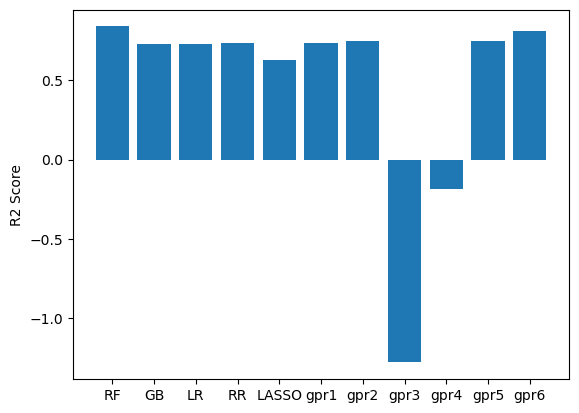

In [31]:
run_models()

In [32]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['mean_A2B', 'mean_X2X', 'mean_A2X', 'E_coh', 'std_A2X', 'std_B2X',
       'OF', 'std_A2B', 'std_X2X', 'TF', 'density', 'mean_B2X'],
      dtype=object)

In [33]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]

RF
R2:  0.8405910988082123
RMSE:  0.10786755017995549
---------------------------------------
GB
R2:  0.7185950222420122
RMSE:  0.14331789441572904
---------------------------------------
LR
R2:  0.7324638117455717
RMSE:  0.1397416281220218
---------------------------------------
RR
R2:  0.7344357568550874
RMSE:  0.1392256746002555
---------------------------------------
LASSO
R2:  0.6267542534553168
RMSE:  0.16505624659410628
---------------------------------------
gpr1
R2:  0.7369589245454992
RMSE:  0.13856269354141304
---------------------------------------
gpr2
R2:  0.7505209701910407
RMSE:  0.13494337086306524
---------------------------------------
gpr3
R2:  -0.18796474378827988
RMSE:  0.29446677995416765
---------------------------------------
gpr4
R2:  -0.18796488641362408
RMSE:  0.2944667976307968
---------------------------------------
gpr5
R2:  0.7497020659621036
RMSE:  0.1351646623341825
---------------------------------------
gpr6
R2:  0.8135603308993072
RMSE:  0.116655089

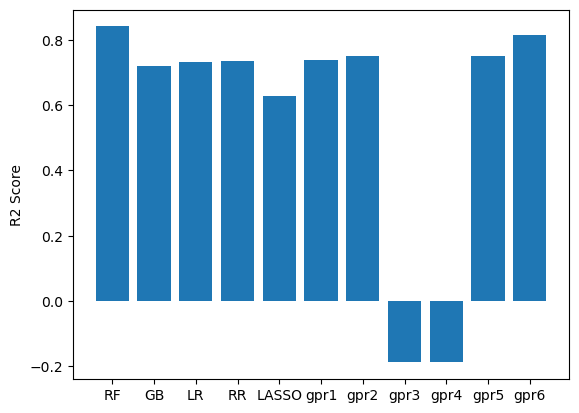

In [34]:
run_models()

In [35]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['mean_A2B', 'mean_X2X', 'mean_A2X', 'E_coh', 'std_A2X', 'std_B2X',
       'OF', 'std_A2B', 'std_X2X', 'TF', 'density', 'mean_B2X'],
      dtype=object)

In [36]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]

RF
R2:  0.8405910988082123
RMSE:  0.10786755017995549
---------------------------------------
GB
R2:  0.7206928775439785
RMSE:  0.14278268239501432
---------------------------------------
LR
R2:  0.7324638117455717
RMSE:  0.1397416281220218
---------------------------------------
RR
R2:  0.7344357568550874
RMSE:  0.1392256746002555
---------------------------------------
LASSO
R2:  0.6267542534553168
RMSE:  0.16505624659410628
---------------------------------------
gpr1
R2:  0.7369589245454992
RMSE:  0.13856269354141304
---------------------------------------
gpr2
R2:  0.7505209701910407
RMSE:  0.13494337086306524
---------------------------------------
gpr3
R2:  -0.18796468072086392
RMSE:  0.2944667721377492
---------------------------------------
gpr4
R2:  -0.18796488641362408
RMSE:  0.2944667976307968
---------------------------------------
gpr5
R2:  0.7497020659621036
RMSE:  0.1351646623341825
---------------------------------------
gpr6
R2:  0.8135603308993072
RMSE:  0.1166550899

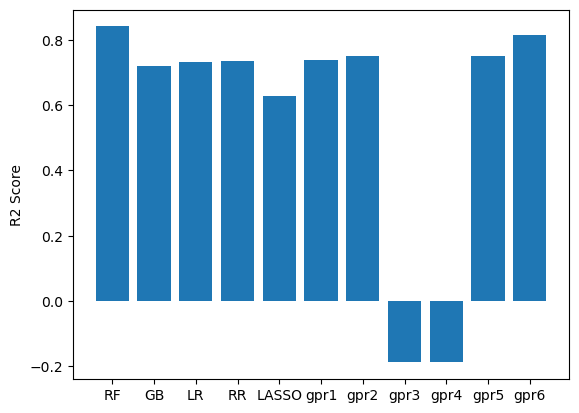

In [37]:
run_models()

In [38]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['mean_A2B', 'mean_X2X', 'mean_A2X', 'E_coh', 'std_A2X', 'std_B2X',
       'OF', 'std_A2B', 'std_X2X', 'TF'], dtype=object)

In [39]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]

RF
R2:  0.8735649310597899
RMSE:  0.09606568993680403
---------------------------------------
GB
R2:  0.6700288266612118
RMSE:  0.15519314415433888
---------------------------------------
LR
R2:  0.6567266061840121
RMSE:  0.15829040971004257
---------------------------------------
RR
R2:  0.659408655518767
RMSE:  0.15767082309777236
---------------------------------------
LASSO
R2:  0.6267542534553168
RMSE:  0.16505624659410628
---------------------------------------
gpr1
R2:  0.6624427400463611
RMSE:  0.15696696378721187
---------------------------------------
gpr2
R2:  0.7046428617764802
RMSE:  0.14682779170065458
---------------------------------------
gpr3
R2:  -0.638078767771503
RMSE:  0.34578163374006127
---------------------------------------
gpr4
R2:  -0.6380798845604345
RMSE:  0.345781751611388
---------------------------------------
gpr5
R2:  0.7769570571425086
RMSE:  0.12759356579579095
---------------------------------------
gpr6
R2:  0.7988714613110589
RMSE:  0.12116338012

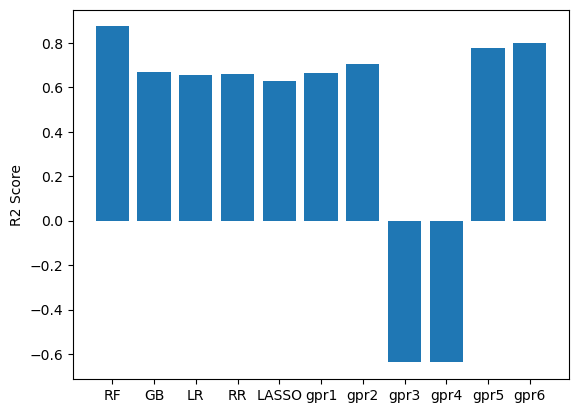

In [40]:
run_models()